# MNIST 데이터셋 분류 예제

- 숫자 이미지에 대한 샘플 데이터 활용

In [15]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

# sklearn.metrics 모듈은 여러가지 평가 지표에 관한 기능을 제공한다.
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

# 랜덤 시드 고정
np.random.seed(777)

In [2]:
# 텐서플로우 저장소에서 데이터를 다운받는다.
(x_train, y_train), (x_test, y_test) = load_data(path = 'mnist.npz')

### 데이터의 형태 확인

숫자 이미지(size: 28px * 28px)와 각 이미지에 해당하는 label(0부터 9까지)로 이루어져 있고, 60,000개의 학습 데이터와 10,000개의 테스트 데이터로 구성되어 있다.

In [3]:
# 훈련 데이터
# x_train -> 숫자이미지들
# y_train -> 이미지들에 대한 실제 숫자 값
print(x_train.shape, y_train.shape)
print(y_train)

(60000, 28, 28) (60000,)
[5 0 4 ... 5 6 8]


In [4]:
# 테스트데이터
print(x_test.shape, y_test.shape)
print(y_test)
print(x_train.shape[0])

(10000, 28, 28) (10000,)
[7 2 1 ... 4 5 6]
60000


임의로 추출할 위치: [47919 15931 52134]


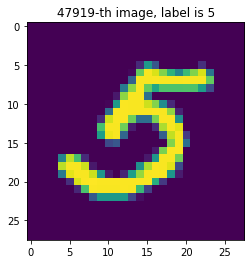

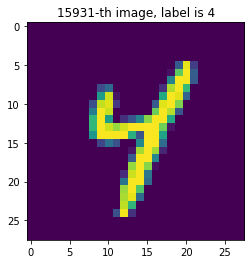

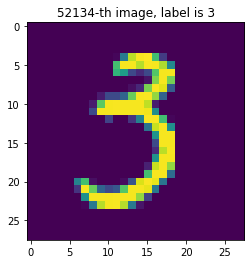

In [5]:
# 임의로 추출할 위치 마련하기
sample_size = 3

# 0 ~ 59999의 범위에서 무작위로 3개의 정수를 뽑습니다.
random_idx = np.random.randint(x_train.shape[0], size = sample_size)
print("임의로 추출할 위치: %s" % random_idx)

# 데이터 그려보기
for idx in random_idx:
    # 이미지 꺼내기
    img = x_train[idx, :]
    
    # 이미지에 대한 답 꺼내기
    label = y_train[idx]
    
    # 그리기
    plt.figure()
    plt.imshow(img)
    plt.title('%d-th image, label is %d' % (idx, label))

### 검증 데이터 만들기
- 훈련 데이터를 일정 비율(7:3)로 훈련 데이터와 검증 데이터로 나누는 과정
- sklearn 패키지의 train_test_split() 함수
    - 데이터 셋을 학습, 검증, 테스트 세트로 분리할 때 사용
    - test_size: 테스트셋의 비율 --> 학습 비율은 "1-테스트셋 비율"
    - random_state: random_seed와 같은 의미. 테스트 도중 매 실행시마다 결과값이 달라지는 것을 방지하기 위해 사용함.

In [12]:
re_x_train = x_train / 255
re_x_test = x_test / 255

# 각 데이터의 레이블을 범주형으로 변경
ca_y_train = to_categorical(y_train)
ca_y_test = to_categorical(y_test)

# 훈련/테스트 데이터를 0.7 / 0.3의 비율로 분리
# -> 기존의 re_x_train, ca_y_train을 각각 re_x_train(7) : re_x_val(3), ca_y_train(7) : ca_y_cal(3) 으로 분리함
re_x_train, re_x_val, ca_y_train, ca_y_val = train_test_split(re_x_train, ca_y_train,
                                                             test_size = 0.3,
                                                             random_state = 777)

### 모델 입력을 위한 전처리

- 신경망은 입력 데이터의 스케일에 매우 민감하므로 적절한 전처리 과정이 필수
    - 그래디언트 손실(Gradient Vanishing)과 그대리언트 폭발(Gradient Exploding)로 인해 학습이 진행되지 않는 현상을 방지하기 위함
- (28 X 28) 2차 배열을 1차원으로 변환
- 2차 배열이 몇 쌍인지를 의미하는 변수
- gif라는 이미지는 팔레트(색깔)가 0-255 범위 안에 존재한다. 한 픽셀 안에 들어가는 색의 값이 0-255라는 뜻.

In [13]:
num_x_train = re_x_train.shape[0]
num_x_val = re_x_val.shape[0]
num_x_test = x_test.shape[0]
print(num_x_train)
print(num_x_val)
print(num_x_test)

42000
18000
10000


### 모델 구성하기 -> Dense층 여러 개 쌓기
- Dense층이 많아질수록 정확성은 좋아지지만 속도가 떨어진다. 
- 여기에 최적화된 층을 쌓는 것은 여러번의 실험을 통해 내가 최적화를 시켜야 한다.
- Dense층을 어떻게 구성해야 할 지를 모르겠으면 마지막 층만 두고 나머지는 다 relu로 시도해본다. 요즘 유행하는 활성함수가 relu

In [16]:
model = Sequential()
model.add(Flatten(input_shape = (28, 28)))
# Dense층의 첫 번째 층은 항상 입력 데이터의 형태(input_shape)를 꼭 명시해야 한다.
# -> 784차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층

model.add(Dense(64, activation = 'relu')) # input_shape 부분 삭제 - 위에서 Flatten으로 실행함
model.add(Dense(32, activation = 'relu')) # 32개의 출력을 가지는 Dense층
model.add(Dense(10, activation = 'softmax')) # 10개의 출력을 가지는 신경망

### 학습과정 설정하기 --> 옵티마이저, 손실함수, 평가지표 설정
다중 분류 무제에서의 손실함수는 'categoriacl_crossentropy' 사용
- 정보 이론에서 파생된 함수
- 실제값과 예측값이 같은 값을 갖는 방향으로 학습된다.
- 실제값과 예측값이 다를 결우 무한대로 발산하게 되고 동일한 경우는 0으로 수렴한다. (로그함수의 특징을 따름)
- 옵티마이저를 어떻게 설정할 지 잘 모르겠으면 adam을 쓴다. 프로그램이 자동으로 설정하도록 맡겨버리는 것!

In [17]:
# adam 옵티마이저 사용 --> 학습률이 0.001로 기본 설정되어 있음.
model.compile(optimizer = 'adam', # 옵티마이저 : Adam
             loss = 'categorical_crossentropy', # 손실 함수: categorical_crossentropy
             metrics = ['acc'])  # 모니터링할 평가지표: acc

### 모델 학습하기
- epoch --> 30회 반복(정확도에 비례함, 속도에 반비례함)
- validation_data 파라미터에 검증 데이터 전달 -> 매 애폭의 끝에서 학습주인 모델에 대한 검증을 수행한다.

In [18]:
result = model.fit(re_x_train, ca_y_train,
                   epochs = 30, 
                   batch_size = 128,
                   validation_data = (re_x_val, ca_y_val))

Epoch 1/30
329/329 [==============================] - 1s 2ms/step - loss: 0.4721 - acc: 0.8689 - val_loss: 0.2438 - val_acc: 0.9312
Epoch 2/30
329/329 [==============================] - 0s 1ms/step - loss: 0.1985 - acc: 0.9435 - val_loss: 0.1817 - val_acc: 0.9472
Epoch 3/30
329/329 [==============================] - 1s 2ms/step - loss: 0.1497 - acc: 0.9550 - val_loss: 0.1516 - val_acc: 0.9557
Epoch 4/30
329/329 [==============================] - 1s 2ms/step - loss: 0.1198 - acc: 0.9651 - val_loss: 0.1321 - val_acc: 0.9622
Epoch 5/30
329/329 [==============================] - 0s 1ms/step - loss: 0.1009 - acc: 0.9705 - val_loss: 0.1281 - val_acc: 0.9632
Epoch 6/30
329/329 [==============================] - 0s 2ms/step - loss: 0.0877 - acc: 0.9741 - val_loss: 0.1149 - val_acc: 0.9659
Epoch 7/30
329/329 [==============================] - 1s 2ms/step - loss: 0.0759 - acc: 0.9771 - val_loss: 0.1168 - val_acc: 0.9646
Epoch 8/30
329/329 [==============================] - 0s 1ms/step - loss: 0.

### history를 통해 확인해볼 수 있는 값 출력하기

In [19]:
# 학습결과(학습 데이터, 검증 데이터, 손실값, 평가지표)를 dictionary로 저장하고 있다.
k = result.history.keys()
k

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

### 학습 결과 DataFrame 생성하기

In [20]:
result_df = DataFrame(result.history, columns = k)
# 이 데이터를 시각화 하거나, 엑셀 혹은 DataBase에 저장 가능하다.
result_df

,loss,acc,val_loss,val_acc
0,0.472090,0.868857,0.243847,0.931167
1,0.198530,0.943548,0.181689,0.947167
2,0.149702,0.955048,0.151625,0.955667
3,0.119791,0.965119,0.132073,0.962222
4,0.100898,0.970452,0.128097,0.963167
5,0.087722,0.974119,0.114911,0.965889
6,0.075922,0.977143,0.116846,0.964556
7,0.067435,0.979476,0.107908,0.967167
8,0.058357,0.982262,0.113591,0.967444
9,0.051826,0.984762,0.107538,0.967667


### 학습 결과 그려보기

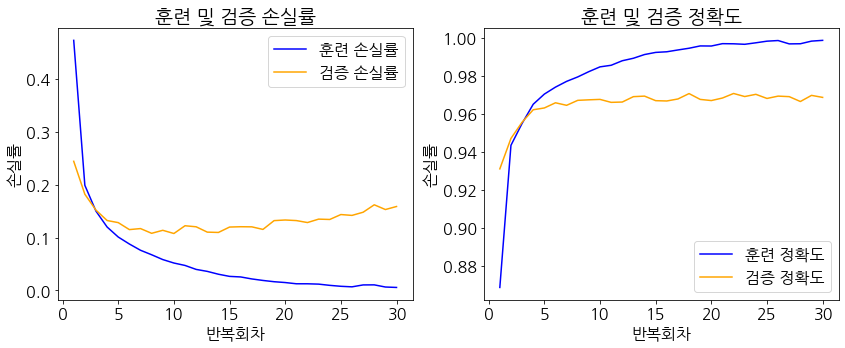

In [21]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (14, 5)

# 그래프를 그리기 위한 객체 생성
fig = plt.figure()

# 1) 훈련 및 검증 손실 그리기

# 훈련 손실률 (y축)
loss = result.history['loss']
# 검증 손실률 (y축)
val_loss = result.history['val_loss']

# 학습회차 (1부터 길이 + 1 전까지) --> x축으로 사용
epochs = range(1, len(loss) + 1)

# 첫 번째 그래프
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = '훈련 손실률')
ax1.plot(epochs, val_loss, color = 'orange', label = '검증 손실률')
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.legend()

# 2) 훈련 및 검증 정확도 그리기

# 훈련 정확도 (y축)
acc = result.history['acc']
# 검증 정확도 (y축)
val_acc = result.history['val_acc']

# 첫 번째 그래프
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = '훈련 정확도')
ax2.plot(epochs, val_acc, color = 'orange', label = '검증 정확도')
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('손실률')
ax2.legend()

plt.show()

### 그래프 설명

- 과대적합 --> 대략 '5에폭'까지는 올바르게 학습되고 있지만, 그 이후에는 두 그래프가 점점 벌어진다.
- 데이터 특성, 모델 구조 등을 수정해보고 재학습시키는 방법이 있지만 먼저 과대적합이 진행되기 전까지의 모델을 사용하여 결과를 확인해보고 기록해두는 것이 좋다. (여기서는 큰 문제가 되지 않으므로 그냥 진행한다.)

In [22]:
# 모델 평가하기 --> 최종 손실값과 정확도가 출력된다.
model.evaluate(re_x_test, ca_y_test)

313/313 [==============================] - 0s 602us/step - loss: 0.1438 - acc: 0.9698


[0.14378641545772552, 0.9697999954223633]

### 학습된 모델을 통해 값 예측하기

In [23]:
# set_printoptions -> 출력 옵션 변경 함수.
# precision --> 소수점 자리수를 의미
np.set_printoptions(precision = 7) # numpy 소수점 제한

results = model.predict(re_x_test)

print(results.shape)

(10000, 10)


In [24]:
data_count, case_count = results.shape
print('%d개의 검증 데이터가 %d개의 경우의 수를 갖는다.' % (data_count, case_count))

10000개의 검증 데이터가 10개의 경우의 수를 갖는다.


In [25]:
# 각각의 검증 데이터가 각 경우의 수에 속할 확률
# 각각의 레이블(숫자 0 ~ 9 : 카테고리 1 ~ 10) 중 각각의 레이블에 속할 확률을 나타낸 것
results

array([[3.5432357e-08, 1.4011970e-12, 3.1923584e-08, ..., 9.9971706e-01,
        2.6218885e-08, 2.8217238e-04],
       [7.3328726e-14, 5.2564808e-08, 1.0000000e+00, ..., 6.2914028e-22,
        1.2889507e-18, 2.5554975e-24],
       [1.8024423e-09, 9.9992335e-01, 1.3959620e-05, ..., 3.2072468e-05,
        6.2157085e-07, 2.0282989e-10],
       ...,
       [4.8814154e-20, 1.1398151e-13, 1.4311383e-24, ..., 2.0632469e-12,
        9.0010128e-17, 3.5851089e-11],
       [2.1608528e-17, 1.2632379e-20, 2.5126894e-20, ..., 2.6480372e-17,
        2.3024902e-09, 1.0057546e-21],
       [1.0409065e-16, 8.1746933e-16, 5.0934228e-20, ..., 3.8022409e-22,
        3.7342116e-20, 1.3067222e-13]], dtype=float32)

In [26]:
# 가장 큰 확률 값의 인덱스 리스트
arg_results = np.argmax(results, axis = -1)
arg_results

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

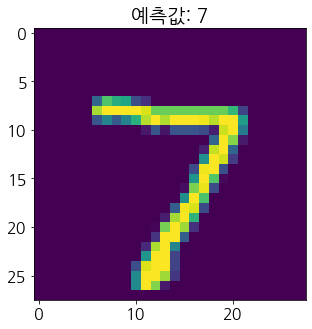

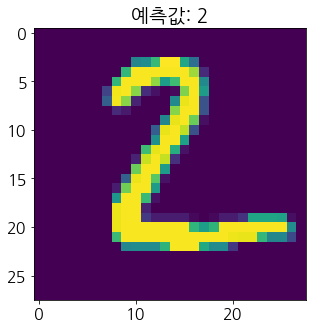

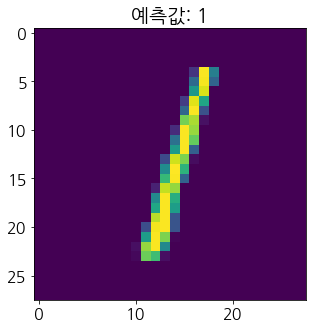

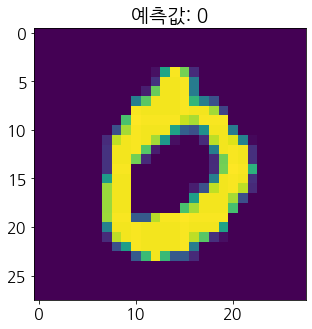

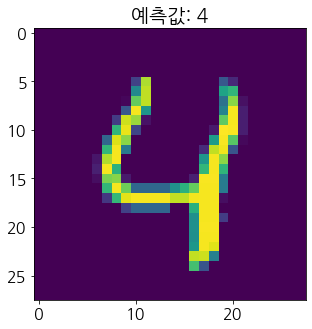

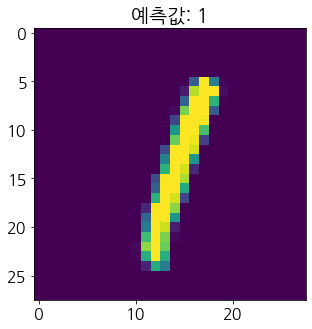

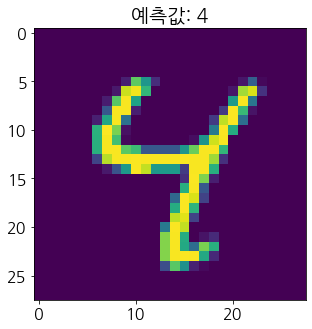

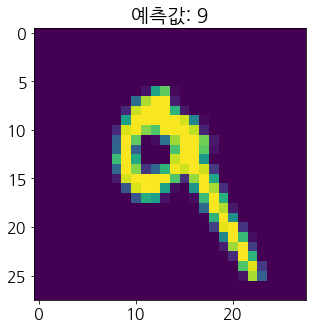

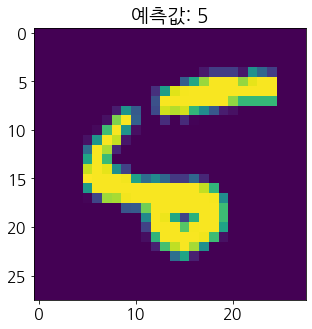

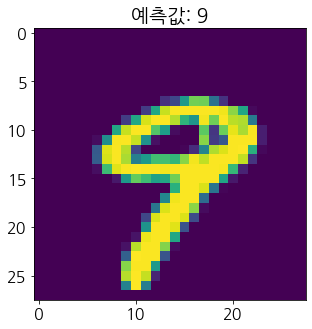

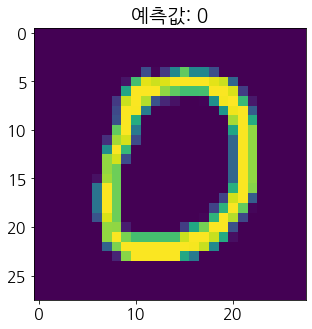

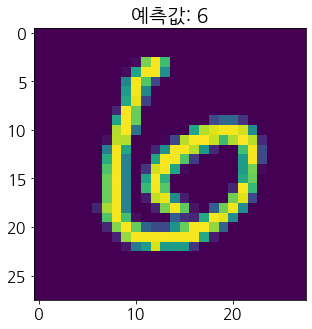

In [27]:
# 예측값 그려서 확인해보기
for i, v in enumerate(arg_results):
    plt.imshow(x_test[i].reshape(28, 28))
    plt.title('예측값: ' + str(v))
    plt.show()
    
    if i > 10:
        break

### 모델 평가 방법 1 : 혼동 행렬
- 숫자가 골고루 퍼져 있을수록 혼란스러워함을 의미

In [28]:
# 예측데이터(ca_y_test)를 x축으로, 결과 데이터(results)를 y축으로 놓는 오차행렬(confusion_matrix) 생성하기
cm = confusion_matrix(np.argmax(ca_y_test, axis = -1), np.argmax(results, axis = -1))
cm

array([[ 968,    0,    0,    0,    0,    2,    3,    3,    1,    3],
       [   0, 1121,    2,    1,    0,    1,    5,    2,    3,    0],
       [   3,    0, 1006,   10,    2,    0,    2,    6,    3,    0],
       [   0,    0,    4,  990,    1,    3,    0,    7,    2,    3],
       [   1,    0,    3,    0,  952,    0,    4,    3,    1,   18],
       [   3,    0,    0,   23,    2,  852,    4,    3,    4,    1],
       [   7,    3,    2,    0,    6,    7,  931,    1,    1,    0],
       [   1,    4,   11,    8,    3,    0,    0,  988,    4,    9],
       [   4,    0,    5,   25,    5,    7,    3,    6,  913,    6],
       [   2,    2,    0,    7,   10,    2,    0,    6,    3,  977]],
      dtype=int64)

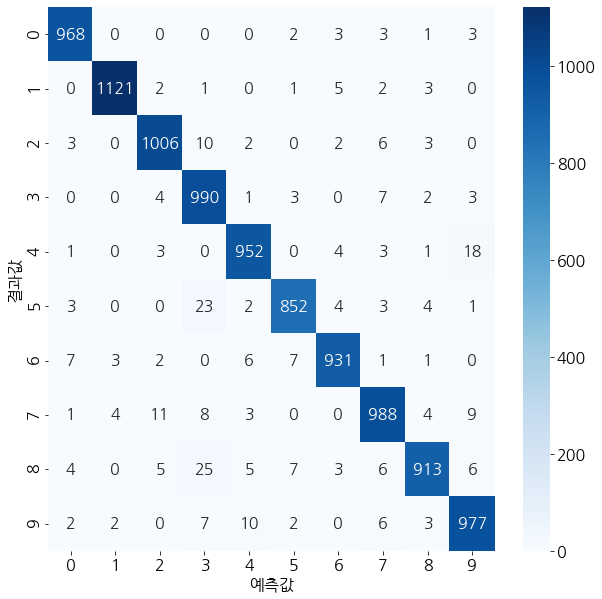

In [29]:
# 오차행렬 시각화
# 5를 분류할 때 가장 많이 혼란스러워한다.
# 오차행렬은 모델의 강점과 약점을 파악하기에 유용하다.

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 10)

# 오차행렬을 히트맵 그래프로 표현
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵(https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('예측값')
plt.ylabel('결과값')
plt.show()

### 모델 평가 방법 2 - 분류 보고서

In [30]:
report = classification_report(np.argmax(ca_y_test, axis = -1),
                              np.argmax(results, axis = -1),
                              output_dict = True)
DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.978766,0.987755,0.983240,980.0000
1,0.992035,0.987665,0.989845,1135.0000
2,0.973863,0.974806,0.974334,1032.0000
3,0.930451,0.980198,0.954677,1010.0000
4,0.970438,0.969450,0.969944,982.0000
5,0.974828,0.955157,0.964892,892.0000
6,0.977941,0.971816,0.974869,958.0000
7,0.963902,0.961089,0.962494,1028.0000
8,0.976471,0.937372,0.956522,974.0000
9,0.960669,0.968285,0.964462,1009.0000
